In [11]:
# base
import pandas as pd
import os
import sys
import numpy as np
import scipy.stats as stats

# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim

# plotting
import matplotlib.pyplot as plt
import datetime

from ray import tune
from ray import train


In [12]:
# Load the data: look at street
data_folder = 'Data'
file_name = 'Street_NL10236-AQ-METEO.csv' #'Urban_NL10418-AQ-METEO.csv' #'Rural_NL10644-AQ-METEO.csv'
data_imported = pd.read_csv(os.path.join(data_folder, file_name), sep=";")
variable = 'no2' # which variable do we want to predict?

In [13]:
class DynamicNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DynamicNN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        
        # Create the first hidden layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        # Create additional hidden layers
        for k in range(len(hidden_sizes)-1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
        
        # Create the output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        
        # Define the activation function
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Pass input through each hidden layer
        for hidden_layer in self.hidden_layers:
            x = self.relu(hidden_layer(x))
        
        # Pass through output layer
        x = self.output_layer(x)
        
        return x


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
def add_time(data):
    data['date'] = pd.to_datetime(data['date'])
    data['Hour of Day'] = data['date'].dt.hour
    data['Day of Year'] = data['date'].dt.dayofyear
    data['Day of Week'] = data['date'].dt.dayofweek
    return data

In [73]:
class OurNN(DynamicNN):
    def __init__(self, hidden_size, output_size, input_arr, labels, learning_rate=0.001, DPI=150, cpu=False):
        
        if cpu:
            self.device = torch.device("cpu")
        else:
            if sys.platform == "darwin":
                self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # for mac
            else:
                self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # for windows

        self.input_arr = input_arr
        self.labels = labels
        self.prepare_data()

        self.input_size = len(self.features)
        self.hidden_size = hidden_size
        self.output_size = output_size

        super(OurNN, self).__init__(self.input_size, self.hidden_size, self.output_size)
        self.criterion = nn.MSELoss()

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.to(self.device) # makes sure that data is created on the right device

        self.prepare_data_for_training()

        # for plots
        self.DPI = DPI
        
    def prepare_data(self):
        # create new data frame with data of interest
        new_data = self.input_arr.copy()
        met_vars_initial = ['wd', 'ws', 't', 'q', 'hourly_rain', 'p', 'n', 'rh']
        new_data = new_data[met_vars_initial + ['date'] + [variable]].dropna()

        # convert time to trainable data
        new_data = add_time(new_data)

        # remove negative concentrations for variable
        new_data.loc[new_data[variable] < 0, variable] = 0

        # rename
        new_column_names = {
            'wd': 'Wind Direction',
            'ws': 'Wind Speed',
            't': 'Temperature',
            'q': 'Specific Humidity',
            'hourly_rain': 'Hourly Rainfall',
            'p': 'Pressure',
            'n': 'Cloud Coverage',
            'rh': 'Relative Humidity'
        }
        new_data.rename(columns=new_column_names, inplace=True)
        met_vars = [new_column_names[var] for var in met_vars_initial]
        features = met_vars + ['Hour of Day', 'Day of Year', 'Day of Week']

        self.met_vars = met_vars
        self.features = features
        self.selected_data = new_data

        return new_data, features

    def prepare_data_for_training(self):
        predictors = self.selected_data[self.features]
        variable_data = self.selected_data[self.labels]

        train_mask = self.selected_data['date'].dt.year <= 2017
        test_mask = self.selected_data['date'].dt.year > 2017

        X_train, y_train = predictors[train_mask], variable_data[train_mask]
        X_test, y_test = predictors[test_mask], variable_data[test_mask]

        t_train = self.selected_data['date'][train_mask]
        t_test = self.selected_data['date'][test_mask]
        
        # Convert Pandas DataFrame and Series to PyTorch Tensor
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
    
        self.X_train = X_train_tensor
        self.y_train = y_train_tensor
        self.t_train = t_train
        self.X_test = X_test_tensor
        self.y_test = y_test_tensor
        self.t_test = t_test

        return X_train_tensor, y_train_tensor, t_train, X_test_tensor, y_test_tensor, t_test
    
    def train(self, num_epochs=100, print_interval=10,return_loss=False):
        loss_arr = []
        for epoch in range(num_epochs):
            # Ensure the data and model are on the same device
            self.X_train = self.X_train.to(self.device)
            self.y_train = self.y_train.to(self.device)
            
            # Forward pass
            outputs = self(self.X_train)
            loss = self.criterion(outputs.view(-1), self.y_train)
            
            # Backward and optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            loss_arr.append(loss.item())
            train.report({'loss': loss.item()})
            
            if (epoch+1) % print_interval == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        if return_loss:
            return loss_arr

    def test(self):
        # Ensure the data and model are on the same device
        self.X_test = self.X_test.to(self.device)
        self.y_test = self.y_test.to(self.device)
        
        # Set the model to evaluation mode
        self.eval()
        
        # Forward pass
        with torch.no_grad():
            outputs = self(self.X_test)
        
        # Calculate the test loss
        test_loss = self.criterion(outputs.view(-1), self.y_test)
        
        print(f'Test Loss: {test_loss.item():.4f}')

        return test_loss


    def predict(self, use_training_data=False):
        self.eval()
        
        if use_training_data:
            input_data = self.X_train.to(self.device)
        else:
            input_data = self.X_test.to(self.device)
        
        with torch.no_grad():
            predictions = self(input_data)
        
        # If predictions are on GPU, you may need to move them to the CPU before further processing
        predictions = predictions.cpu()

        if use_training_data:
            self.y_train_pred = predictions
        else:
            self.y_test_pred = predictions
        return predictions


    def plot_pred(self, all=True, start_month=1, start_day=1, n_months=3, n_days=0):
        if not hasattr(self, 'y_test_pred'):
            self.predict(use_training_data=False)
        if not hasattr(self, 'y_train_pred'):
            self.predict(use_training_data=True)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, dpi=self.DPI, figsize=(10, 4), sharey=True)
        ax1.plot(self.t_train, self.y_train.cpu().numpy(), alpha=.5, label='Observation', color='tab:blue')
        ax1.plot(self.t_train, self.y_train_pred.cpu().numpy(), alpha=.5, label='Prediction', color="tab:purple")
        ax1.set_ylim(0, 120)
        ax1.legend(loc='upper right')
        ax1.grid(True)
        ax1.set_ylabel(r'[$NO_2$] ($\mu g/m^3$)')
        ax1.set_title('Training Set')

        ax2.plot(self.t_test, self.y_test.cpu().numpy(), alpha=.5, label='Observation', color='tab:orange')
        ax2.plot(self.t_test, self.y_test_pred.cpu().numpy(), alpha=.5, label='Prediction', color="tab:red")
        ax2.grid(True)
        ax2.set_xlabel('Date')
        ax2.set_ylabel(r'[$NO_2$] ($\mu g/m^3$)')
        ax2.legend(loc='upper right')
        ax2.set_title('Test Set')

        if not all:
            ax1.set_xlim(datetime.date(2017, start_month, start_day), datetime.date(2017, start_month + n_months, start_day + n_days))
            ax2.set_xlim(datetime.date(2018, start_month, start_day), datetime.date(2018, start_month + n_months, start_day + n_days))

        plt.tight_layout()
        plt.show()

    def compare_pred_vs_test(self, label_pred='Predicted', label_test='Observed'):
        if not hasattr(self, 'y_test_pred'):
            self.predict(use_training_data=False)

        #y_pred = np.array(self.y_test_pred).reshape(-1)
        #y_test = np.array(self.y_test).reshape(-1)

        kde_pred = stats.gaussian_kde(self.y_train)
        kde_test = stats.gaussian_kde(self.y_test)

        xs_pred = np.linspace(min(self.y_train) - 1, max(self.y_train) + 1, len(self.y_train))
        xs_test = np.linspace(min(self.y_test) - 1, max(self.y_test) + 1, len(self.y_test))

        pdf_pred = kde_pred(xs_pred)
        pdf_test = kde_test(xs_test)

        plt.plot(xs_pred, pdf_pred, color='r', label=label_pred)
        plt.plot(xs_test, pdf_test,label=label_test)
        plt.legend()
        plt.xlabel('NO$_2$ concentration [$\mu$g /m$^3$]')
        plt.ylabel('Probability Density []') 
        plt.title('Probability Distribution') 
        plt.savefig('pred_test')
        plt.show()




In [74]:
hidden_size = 128
output_size = 1
our_nn_model = OurNN(hidden_size=[128], output_size=1, input_arr=data_imported, labels=variable, learning_rate=0.001, cpu=False)

In [75]:
our_nn_model.train(num_epochs=500, print_interval=100)

Epoch [100/500], Loss: 189.0325
Epoch [200/500], Loss: 170.0928
Epoch [300/500], Loss: 153.8255
Epoch [400/500], Loss: 137.6133
Epoch [500/500], Loss: 125.1590


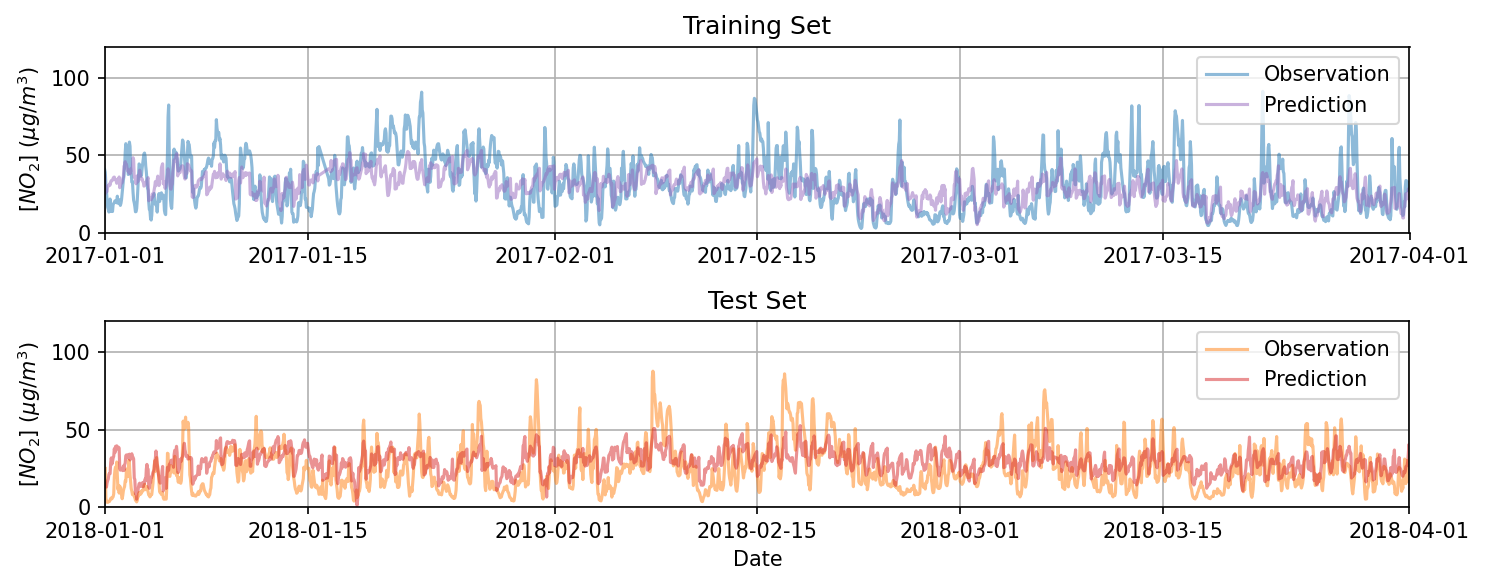

In [76]:
our_nn_model.plot_pred(all=False, n_months=3)

In [21]:
our_nn_model.test()

Test Loss: 110.9685


tensor(110.9685)

In [22]:
from ray import tune
from ray.air import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler

In [27]:
from ray import tune

def train_model(config):
    '''function to optimize hyperparameters'''
    model = OurNN(hidden_size=config["hidden_size"],output_size=1,input_arr=data_imported, labels=variable, learning_rate=config["lr"], cpu=False)

    model.train(num_epochs=10000, print_interval=5000) #set print interval high since we fit this 500 times lol


In [28]:
from ray.tune.schedulers import ASHAScheduler
def ray_tuner(max_t=10000,gp=1500,reduction_f=2,num_samples=25):
    config = {
        "lr": tune.loguniform(1e-4, 1e-2), #logarithmic sampling for learning rate
        "hidden_size": tune.choice([[128,64],[512],[256,128],[512,256],[512,128],[256,64],[128],[256], [512,256,128]]) #hidden size in form of 2**n
    }

    scheduler = ASHAScheduler(
        max_t=max_t, #max_t should be equal to num_epochs
        grace_period=gp, #should be minimum amounts of epochs before it fucks off
        reduction_factor=reduction_f) #reduction factor determines how many trials are kept after each round of successive halving. could be set to two idealy, takes longer

    analysis = tune.run(
        train_model,
        resources_per_trial={"GPU": 1, 'cpu': 13}, #depends on model's capacity. I have 16 cpu's and 1 gpu. If I set all 16 cpu's available my laptop crashes
        config=config,
        num_samples=num_samples, #number of runs
        scheduler=scheduler,
        metric="loss", #that what we want to evaluate
        mode="min") #we try to minimise loss not maximise it

    print("Best hyperparameters found were: ", analysis.best_config)
    return analysis.best_config


In [91]:
best_config_output = ray_tuner(max_t=130000,gp=2000,num_samples=150)

2023-10-30 17:05:05,340	INFO tune.py:645 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2023-10-30 17:05:12,874	WARNING worker.py:2058 -- Warning: The actor ImplicitFunc is very large (23 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Trial name,loss
train_model_173c0_00000,72.1133


(train_model pid=25408) Epoch [5000/10000], Loss: 83.0639


In [30]:
best_config_output

{'lr': 0.0007747064379665419, 'hidden_size': [128, 64]}

In [86]:
our_nn_model_optimised = OurNN(hidden_size=best_config_output['hidden_size'], output_size=1, input_arr=data_imported, labels=variable, learning_rate=best_config_output['lr'], cpu=False)
loss_arr = our_nn_model_optimised.train(num_epochs=20000, print_interval=1000, return_loss=True)

Epoch [1000/20000], Loss: 114.3102
Epoch [2000/20000], Loss: 88.9194
Epoch [3000/20000], Loss: 84.9585
Epoch [4000/20000], Loss: 82.8301
Epoch [5000/20000], Loss: 81.0330
Epoch [6000/20000], Loss: 79.4182
Epoch [7000/20000], Loss: 77.6254
Epoch [8000/20000], Loss: 76.3090
Epoch [9000/20000], Loss: 75.3632
Epoch [10000/20000], Loss: 74.2030
Epoch [11000/20000], Loss: 70.7050
Epoch [12000/20000], Loss: 68.1463
Epoch [13000/20000], Loss: 67.0183
Epoch [14000/20000], Loss: 65.0617
Epoch [15000/20000], Loss: 63.9944
Epoch [16000/20000], Loss: 63.2649
Epoch [17000/20000], Loss: 62.7208
Epoch [18000/20000], Loss: 62.3188
Epoch [19000/20000], Loss: 63.5082
Epoch [20000/20000], Loss: 63.9034


Text(0, 0.5, 'Loss')

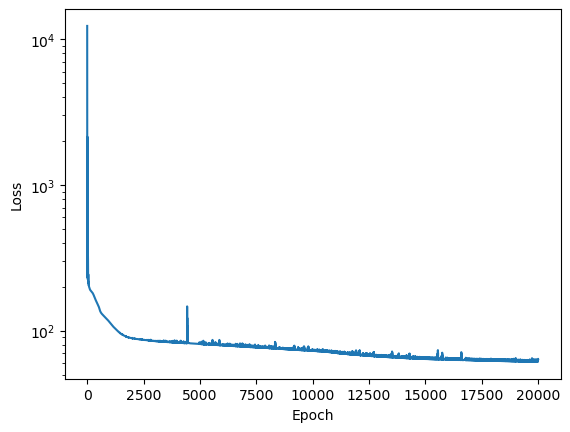

In [88]:
plt.plot(loss_arr)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

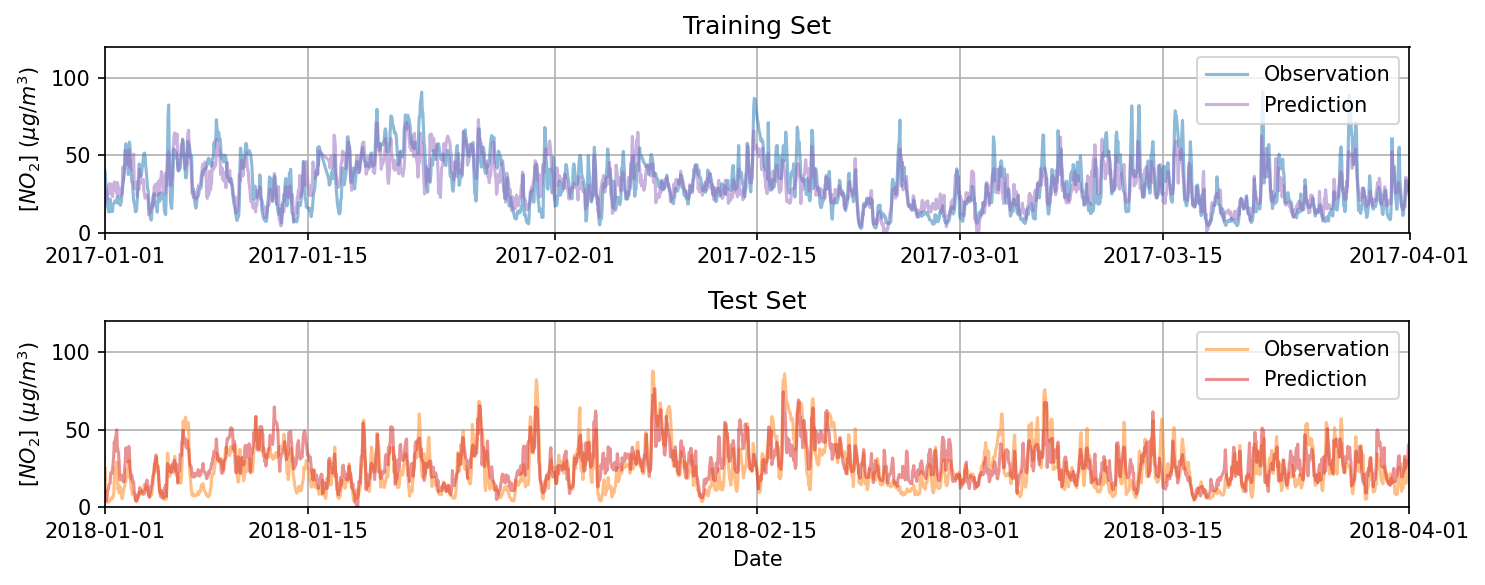

In [79]:
our_nn_model_optimised.plot_pred(all=False, n_months=3)

In [89]:
our_nn_model_optimised.test()

Test Loss: 75.5195


tensor(75.5195, device='cuda:0')

In [90]:
np.sqrt(75)

8.660254037844387